<h1>Transfer Learning with Lightning<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lightning-Module" data-toc-modified-id="Lightning-Module-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lightning Module</a></span></li><li><span><a href="#Lightning-Data-Module" data-toc-modified-id="Lightning-Data-Module-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Lightning Data Module</a></span></li><li><span><a href="#Hyperparameters" data-toc-modified-id="Hyperparameters-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyperparameters</a></span></li><li><span><a href="#Trainer" data-toc-modified-id="Trainer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Trainer</a></span><ul class="toc-item"><li><span><a href="#Tensorboard-Dashboard" data-toc-modified-id="Tensorboard-Dashboard-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Tensorboard Dashboard</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training</a></span></li></ul></li><li><span><a href="#Model-Loading-and-Inference" data-toc-modified-id="Model-Loading-and-Inference-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Loading and Inference</a></span></li><li><span><a href="#References" data-toc-modified-id="References-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>References</a></span></li></ul></div>

* V této jednotce se naučíte používat PyTorch Lightning pro trénink přenosu učení.

* Jakmile je předtrénovaný model načten, trénink se neliší od standardního modelového tréninku.

* Nejdůležitějším úkolem je tedy vědět, jak načíst předem trénovaný model pomocí PyTorch Lightning.

* `LightningModule` je `torch.nn.Module` s přidanými funkcemi, načte modely z `torchvision.models` jako modely PyTorch Lightning

**Jakmile je model načten, víte, jak jej pomocí `Lightning` trénovat.**

In [1]:
!pip install lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 17.5 MB/s eta 0:00:0000:01


In [2]:
import os

# filter UserWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.pyplot as plt  
%matplotlib inline

In [3]:
try:
    import lightning.pytorch as pl
except ImportError:
    !pip -qU install lightning torchmetrics
    import lightning.pytorch as pl

In [4]:
from dataclasses import dataclass
import os

# Importing EarlyStopping callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

# Use Module API to track and compute metrics automatically
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassAccuracy

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models
from torchvision import datasets, transforms

torch.multiprocessing.set_start_method('spawn', force=True)

In [5]:
torch.set_float32_matmul_precision('high')

## Modul Lightning

**We have chosen the ResNet family for transfer learning/fine-tuning.**

- The ResNet family model has five  layers: `layer1`, `layer2`, `layer3`, `layer4`, and `fc`.


- It is mandatory to replace (and re-train) the last fully connected layer (`fc`) for fine-tuning. 


- How many more layers should be fine-tuned to get the best result is something you will know only by practically working on it each time. So, we have written a `LightningModule` class that takes `fine_tune_start` as an argument and updates the `requires_grad` parameters  of the ResNet model accordingly.

In [6]:
class TransferLearningWithResNet(pl.LightningModule):
    def __init__(
        self,
        resnet_model_name="resnet18",
        weights="DEFAULT",
        fine_tune_start=1,
        learning_rate=0.01,
        num_classes=10,
    ):
        super().__init__()

        self.save_hyperparameters()

        resnet = getattr(models, self.hparams.resnet_model_name)(
            weights=self.hparams.weights
        )

        if self.hparams.weights:
            for param in resnet.parameters():
                param.requires_grad = False

        if self.hparams.weights and self.hparams.fine_tune_start <= 1:
            for param in resnet.layer1.parameters():
                param.requires_grad = True

        if self.hparams.weights and self.hparams.fine_tune_start <= 2:
            for param in resnet.layer2.parameters():
                param.requires_grad = True

        if self.hparams.weights and self.hparams.fine_tune_start <= 3:
            for param in resnet.layer3.parameters():
                param.requires_grad = True

        if self.hparams.weights and self.hparams.fine_tune_start <= 4:
            for param in resnet.layer4.parameters():
                param.requires_grad = True

        last_layer_in = resnet.fc.in_features
        resnet.fc = nn.Linear(last_layer_in, self.hparams.num_classes)

        self.resnet = resnet

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_acc = MulticlassAccuracy(num_classes=self.hparams.num_classes, average="micro")

    def forward(self, x):

        return self.resnet(x)


    def training_step(self, batch, *args, **kwargs):

        # get data and labels from batch
        data, target = batch

        # get prediction
        output = self(data)

        # calculate batch loss
        loss = F.cross_entropy(output, target)

        # Batch Predictions.
        pred_batch = output.detach().argmax(dim=1)

        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_acc(pred_batch, target)

        # Arguments such as on_epoch, on_step and logger are set automatically depending on
        # hook methods it's been called from
        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=True)

        # logging and adding current batch_acc to progress_bar
        self.log("train/batch_acc", self.mean_train_acc, prog_bar=True, logger=True)

        return loss

    
    def on_train_epoch_end(self):
        """Calculate epoch level metrics for the train set"""
        
        self.log("train/loss", self.mean_train_loss, prog_bar=True, logger=True)
        self.log("train/acc", self.mean_train_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    
    def validation_step(self, batch, *args, **kwargs):

        # get data and labels from batch
        data, target = batch

        # get prediction
        output = self(data)

        # calculate loss
        loss = F.cross_entropy(output, target)

        # Batch Predictions.
        pred_batch = output.argmax(dim=1)

        # Update logs.
        self.mean_valid_loss(loss, weight=data.shape[0])
        self.mean_valid_acc(pred_batch, target)
        

    def on_validation_epoch_end(self):
        """Calculate epoch level metrics for the validation set"""

        self.log("valid/loss", self.mean_valid_loss, prog_bar=True, logger=True)
        self.log("valid/acc", self.mean_valid_acc, prog_bar=True, logger=True)
        self.log("step", self.current_epoch, logger=True)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate)

## Lightning Datový Modul

Budeme používat datovou sadu z kaggle. <a target="_blank" href="https://www.kaggle.com/ashishsaxena2209/animal-image-datasetdog-cat-and-panda"><strong>Podívejte se na to zde</strong></a>

Skládá se z `1000` obrázků každého z více zvířat, přičemž všechny obrázky konkrétního zvířete jsou v samostatné složce. Rozdělili jsme jej na poměr `80:20` pro `train: validation`, který si můžete stáhnout <a target="_blank" href="https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1"><strong>tady</strong></a>.


**Vytvoříme datový modul Lightning.**

* Stáhneme si naši datovou sadu z výše uvedeného odkazu pomocí vestavěné metody `download_url` torchvision a rozbalíme ji pomocí vestavěné knihovny `zipfile` pythonu.
* Struktura složek uvnitř souboru zip je následující: 

```bash
├───cat-dog-panda
│   ├───training
│   │   ├───cat
│   │   ├───dog
│   │   └───panda
│   └───validation
│       ├───cat
│       ├───dog
│       └───panda
```

* Protože již známe jméno `root_dir`, tj. **"cat-dog-panda"**, nepotřebujeme další argument.

In [7]:
import os
import zipfile
import torchvision

class CatDogPandaDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, num_workers):

        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers

        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

        preprocess = transforms.Compose(
            [transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor()]
        )

        self.common_transforms = transforms.Compose(
            [preprocess, transforms.Normalize(mean, std)]
        )

        self.aug_transforms = transforms.Compose(
            [
                transforms.RandomResizedCrop(256),
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.3
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(90),
                transforms.RandomGrayscale(p=0.1),
                self.common_transforms,
                transforms.RandomErasing(),
            ]
        )

    def prepare_data(self):

        curr_dir = os.getcwd()
        print("Preparing Cat, Dog, Panda dataset")
        url = (
            "https://www.dropbox.com/sh/n5nya3g3airlub6/AACi7vaUjdTA0t2j_iKWgp4Ra?dl=1"
        )
        filename = os.path.join(curr_dir, r"animal-data.zip")
        root = curr_dir

        torchvision.datasets.utils.download_url(url, root, filename)

        with zipfile.ZipFile(filename, "r") as f:

            # list the folders present in the zipfile
            directories = [info.filename for info in f.infolist() if info.is_dir()]

            # index 1 contatins the name of the root directory we are interested in
            # ["/", "cat-dog-panda/", "cat-dog-panda/training", ...]
            self.data_root = os.path.join(curr_dir, directories[1])

            # if data has not been extracted already (useful when experimenting again)
            # avoids extracting if dataset already extracted before
            if not os.path.isdir(self.data_root):
                # extract the zipfile contents
                f.extractall(curr_dir)

        print("Preparation completed.")

    def setup(self, stage=None):
        train_data_path = os.path.join(self.data_root, "training")
        val_data_path = os.path.join(self.data_root, "validation")

        self.train_dataset = datasets.ImageFolder(
            root=train_data_path, transform=self.aug_transforms
        )
        self.val_dataset = datasets.ImageFolder(
            root=val_data_path, transform=self.common_transforms
        )

    def train_dataloader(self):
        # train loader
        train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )
        return train_loader

    def val_dataloader(self):
        # validation loader
        test_loader = torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )
        return test_loader

## Hyperparametry

In [8]:
@dataclass(frozen=True)
class DataConfiguration:
    data_root: str = f"data"
    num_workers: int = 8
    batch_size: int = 128
    num_classes = 3

In [9]:
@dataclass(frozen=True)
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    model_name: str = f"resnet18"
    weights: str = "DEFAULT"
    epochs: int = 20    
    learning_rate: float = 1e-3  # initial learning rate for lr scheduler
    fine_tune_start: int = 3
    precision: str = "16-mixed"

In [10]:
data_config = DataConfiguration()
train_config = TrainingConfiguration()

## Trenér (Trainer)

In [11]:
def training_validation():
    pl.seed_everything(21, workers=True)

    # init model

    model = TransferLearningWithResNet(
        resnet_model_name=train_config.model_name,
        weights=train_config.weights,
        fine_tune_start=train_config.fine_tune_start,
        num_classes=data_config.num_classes,
        learning_rate=train_config.learning_rate,
    )

    data_module = CatDogPandaDataModule(
        batch_size=data_config.batch_size, num_workers=data_config.num_workers
    )
    
    checkpoint_callback = ModelCheckpoint(
        monitor='valid/acc',
        mode="max",
        filename='transfer_learning-resnet18-epoch-{epoch:02d}',
        auto_insert_metric_name=False,
        save_weights_only=True
    )
    
    early_stopping_callback = EarlyStopping(monitor="valid/loss") 

    # most basic trainer, uses good defaults
    trainer = pl.Trainer(
                accelerator="auto", 
                devices="auto",  
                strategy="auto", 
                max_epochs=train_config.epochs,  
                precision = train_config.precision, 
                callbacks=[
                    early_stopping_callback,                                                         
                    checkpoint_callback
                ]  
            )

    trainer.fit(model, data_module)

    return model, data_module, checkpoint_callback

### Tensorboard Dashboard

In [12]:
# # To reload tensorBoard
# %load_ext tensorboard

# # logs folder path
# %tensorboard --logdir=lightning_logs

### Trénink

In [13]:
model, data_module, model_ckpt = training_validation()

INFO: Seed set to 21
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 144MB/s] 
INFO: Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


Preparing Cat, Dog, Panda dataset


100%|██████████| 197683526/197683526 [00:37<00:00, 5240687.05it/s] 


Preparation completed.


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
INFO: 
  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | resnet          | ResNet             | 11.2 M | train
1 | mean_train_loss | MeanMetric         | 0      | train
2 | mean_train_acc  | MulticlassAccuracy | 0      | train
3 | mean_valid_loss | MeanMetric         | 0      | train
4 | mean_valid_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------------
10.5 M    Trainable params
683 K     Non-trainable params
11.2 M    Total params
44.712    Total estimated model params size (MB)
72        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=20` reached.


## Načtení modelu a odvození hodnot

Metoda sample_prediction bere jako argumenty `model`, `data_module` a `ckpt_path`. 
- Načtěte kontrolní bod z dané cesty `ckpt_path`,,
- Získejte zavaděč ověřovacích dat z `data_module`,
- Udělejte závěry na jedné dávce a zakreslete je 

In [14]:
import random
import numpy as np

# convert image tensor to PIL image and in range 0-255
from torchvision.transforms.functional import to_pil_image


def denormalize(tensors):
    """Denormalizes image tensors back to range [0.0, 1.0]"""

    mean = torch.Tensor([0.485, 0.456, 0.406])
    std = torch.Tensor([0.229, 0.224, 0.225])
    
    tensors = tensors.clone()
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors.cpu(), 0.0, 1.0)


def sample_prediction(model, data_module, ckpt_path):
    random.seed(1)

    # load model from checkpoint
    ckpt_model = TransferLearningWithResNet.load_from_checkpoint(ckpt_path)
    # freeze model for inference
    ckpt_model.freeze()
    
    # run model in evaluation mode
    ckpt_model.eval()

    # get val_dataloader for data_module
    val_data = data_module.val_dataloader()
    
    idx_to_class = {j: i for i, j in data_module.val_dataset.class_to_idx.items()}

    imgs = []
    preds = []
    probs = []

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    ckpt_model.to(device)

    for data, _ in val_data:

        with torch.no_grad():
            output = ckpt_model(data.to(device))

        # get probability score using softmax
        prob = F.softmax(output, dim=1)

        # get the max probability
        pred_prob = prob.data.max(dim=1)[0]

        # get the index of the max probability
        pred_index = prob.data.max(dim=1)[1]
        # pass the loaded model
        pred = pred_index.cpu().tolist()
        prob = pred_prob.cpu().tolist()

        imgs.extend([np.asarray(to_pil_image(image)) for image in denormalize(data)])

        preds.extend(pred)
        probs.extend(prob)
        break
        
    # randomly select 6 images fom the first batch
    random_6 = random.sample(list(zip(imgs, preds, probs)), 6)

    plt.figure(figsize=(12, 15))

    for idx, (img, pred, prob) in enumerate(random_6, 1):
        img = np.array(img).reshape(224, 224, 3)
        plt.subplot(3, 2, idx)
        plt.imshow(img)
        plt.title(f"Prediction: {idx_to_class[pred]}, Prob: {prob:.2f}")
        plt.axis("off")

    plt.show()

    return

The latest model path: /kaggle/working/lightning_logs/version_0/checkpoints/transfer_learning-resnet18-epoch-18.ckpt


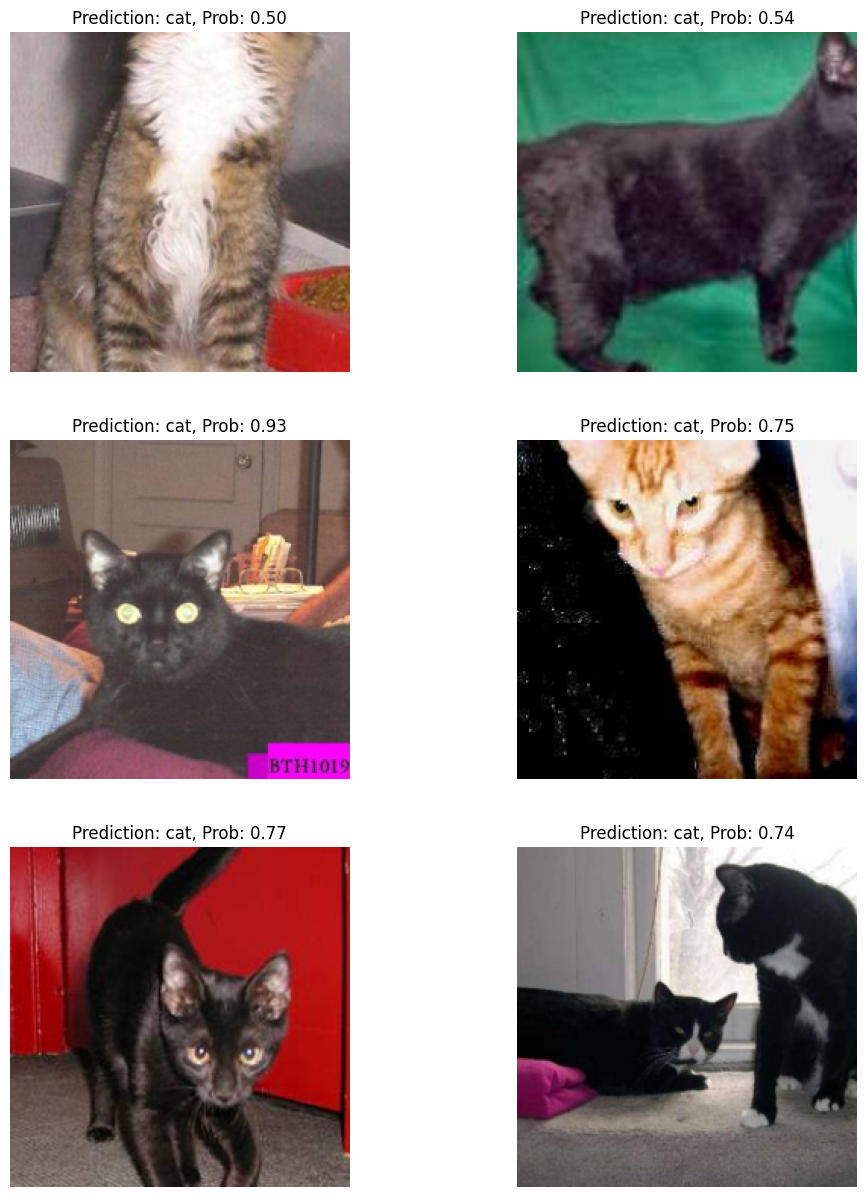

In [15]:
# get checkpoints of the latest run
ckpt_path = model_ckpt.best_model_path
print('The latest model path: {}'.format(ckpt_path))

# sample prediction
sample_prediction(model, data_module, ckpt_path)

## Reference

1. <a target="_blank" href="https://pytorch.org/tutorials/beginner/data_loading_tutorial.html">https://pytorch.org/tutorials/beginner/data_loading_tutorial.html</a>
2. <a target="_blank" href="https://pytorch.org/tutorials/beginner/saving_loading_models.html">https://pytorch.org/tutorials/beginner/saving_loading_models.html</a>
3. <a target="_blank" href="https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=gEulmrbxwaYL">https://colab.research.google.com/drive/1F_RNcHzTfFuQf-LeKvSlud6x7jXYkG31#scrollTo=gEulmrbxwaYL</a>
4. <a target="_blank" href="https://pytorch-lightning.readthedocs.io/en/latest/">https://pytorch-lightning.readthedocs.io/en/latest/</a>
5. <a target="_blank" href="https://github.com/PyTorchLightning/pytorch-lightning">https://github.com/PyTorchLightning/pytorch-lightning</a>
6. <a target="_blank" href="https://www.youtube.com/watch?v=QHww1JH7IDU">https://www.youtube.com/watch?v=QHww1JH7IDU</a>
7. <a target="_blank" href="https://www.youtube.com/channel/UC8m-y0yAFJpX0hRvxH8wJVw/featured">https://www.youtube.com/channel/UC8m-y0yAFJpX0hRvxH8wJVw/featured</a>